In [650]:

import numpy as np

import xarray as xr
from xarray.plot.plot import _infer_interval_breaks as infer_interval_breaks
import pandas as pd



kB = 1.38064852e-23 # Boltzmann constant

# The input are: diameter1, density1, diameter2, density2, temperature, pressure, mass accomodation coefficient
# The output is : coagulation coefficient between two particles (in air), in m^3/s
# Considering that T and P may vary with time in some appications and the d1, d2 arrays may not be predetermined
# we use a least efficient way to calculate the coagulation coefficient
def CalCoagCoefFuchs(d1, dens1, d2, dens2, T, P , alpha ):
    m1 = dens1 * np.pi/6*d1**3
    m2 = dens2 * np.pi/6*d2**3
    mfp = CalMFP(T, P)
    vis = CalVis(T)
    Kn1 = CalKn(d1, mfp)
    Kn2 = CalKn(d2, mfp)
    Cs1 = CalCs(Kn1)
    Cs2 = CalCs(Kn2)
    diff1 = CalDiffusivity(d1, Cs1, vis, T)
    diff2 = CalDiffusivity(d2, Cs2, vis, T)
    v1 = CalVelocity(m1, T)
    v2 = CalVelocity(m2, T)
    l1 = 8*diff1/np.pi/v1
    l2 = 8*diff1/np.pi/v2
    g1 =np.sqrt(2)/(3*d1*l1) * ( (d1+l1)**3 - (d1**2+l1**2)**(3/2) ) -d1
    g2 =np.sqrt(2)/(3*d2*l2) * ( (d2+l2)**3 - (d2**2+l2**2)**(3/2) ) -d2
    a = 2*np.pi*(diff1+diff2)*(d1+d2)
    b = (d1+d2)/(d1+d2+2*np.sqrt(g1**2+g2**2))
    c = 8/alpha*(diff1+diff2)/np.sqrt(v1**2+v2**2)/(d1+d2)
    return a/(b+c)



# Mean free path of air, Eq. 2-10, P19, Aerosol Measurement, Third Edition
def CalMFP(T ,P):
    a = 66.5 * 10 ** -9
    b = (101325 / P)
    c = (T / 293.15)
    d = (1 + 110.4 / 293.15)
    e = (1 + 110.4 / T)
    return a * b * c * d / e  # in m


# Dynamic viscosity (rather than kinetic viscosity which is divided by density)
# of air using Sutherland equation, Eq. 2-8, P18, Aerosol Measurement, Third Edition
def CalVis(T ):
    a = 18.203 * 10 ** -6
    b = (293.15 + 110.4)
    c = (T + 110.4)
    d = (T / 293.15) ** 1.5
    return a * b / c * d  # Pa*s

# Knudsen number
def CalKn(dp, mfp):
    return 2*mfp/dp


# Cunningham slip correction factor, equation and parameters by Allen & Raabe 1985, for solid particles
# Can also be found in Eq. 2-14, P20,  Aerosol Measurement, Third Edition
def CalCs(Kn):
    alpha = 1.142
    beta = 0.558
    gamma = 0.999
    a = np.exp(-gamma / Kn)
    return 1 + Kn*(alpha + beta * a)

# Diffusion coefficient
def CalDiffusivity(dp, Cs, vis, T):
    a = (3 * np.pi * vis * dp)
    b = kB * T * Cs
    return b / a  # in m^2/s

# Calculate particle thermal velocity (RMS), in m/s
def CalVelocity(m, T): # m mass in kg
    a = 8 * kB * T
    b = a / np.pi
    return np.sqrt(b / m)

# #####
# # an example is given below
# dp = collect(10 .^(0:0.1:3))*1e-9 # 1-1000 nm
# dNdlogdp = ones(length(dp)) # the measured dN/dlogdp or dN/dp
# # first, convert dN/dlogdp to dN, unless the raw data is dN already
# dlogdp = vcat(log10(dp[2]/dp[1]), # Julia starts from 1, not zero
#               [log10(dp[ii+1]/dp[ii]) for ii in 2:length(dp)-1],log10(dp[end]/dp[end-1]))
# dN = dNdlogdp .* dlogdp # number concentration in m^-3 for each size bin. N_total = sum(dN) for every dp
# # second, let's calculate the coagulation coefficients, beta (m^3/s) between every new particle and every larger particle
# dpnew = dp[3:11] # 1.5 - 10 nm particles, for example
# dNnew = dN[3:11]
# dens1 = dens2 = 1200 # density, in kg/m3
# beta = [CalCoagCoefFuchs(dpnew[ii], dens1, dp[jj], dens2) for ii in eachindex(dpnew), jj in eachindex(dp)] # eachindex() is equal to 1:length(dp)
# # third, the coagulation sink as a function of dpnew (CoagS in 1/s) can be calculated as
# CoagS = [sum(beta[ii,:].*dN) for ii in eachindex(dpnew)]
# # finally, the CoagSnk term (in m^-3 s^-1) is obtained by calculating dot(CoagS, dpnew), i.e.,
# CoagSnk = sum(CoagS.*dNnew)
# # J = dN/dt + net CoagSnk + GR term = dN/dt + CoagSnk - CoagSrc + GR term
# # We can discuss how to calculate J after this CoagS

def test_CoagSnk():
    dp = 10**np.arange(0,3.001,.1) * 1e-9

    dNdlogdp = np.ones(len(dp))

    a = np.log10(dp[1:]/dp[0:-1])
    dlogdp = [*a,a[-1]]

    dN = dNdlogdp * dlogdp

    dpnew = dp[2:11]
    dNnew = dN[2:11]

    dens1 = dens2 = 1200

    beta =np.array([[CalCoagCoefFuchs(dpn, dens1, dp_, dens2,T = 293.15, P = 101325, alpha = 1) for dpn in dpnew] for dp_ in dp])

    #     print(sum(sum(beta)))
    #     print(sum(beta))

    CoagS = [sum(b_*dN) for b_ in beta.T]

    #     print(CoagS)

    CoagSnk = sum(CoagS*dNnew)
    test = 4.486361877087417e-12
    assert CoagSnk == test , f'{CoagSnk} is not {test}'
    return True



def test_xarray_form():


    dp = 10**np.arange(0,3.001,.1) * 1e-9

    dNdlogdp = np.ones(len(dp))

    da = xr.DataArray(dNdlogdp,dims='Dp',coords={'Dp':dp})
    da.name = 'dndlDp'

    da['lDp'] = np.log10(da['Dp'])


    da['dlDp']=da['lDp']*0+pd.Series(infer_interval_breaks(da['lDp'] ,check_monotonic=True)).diff().dropna().values
    da['dN'] = da*da['dlDp']
    daN = da['dN']


    d1 = 1.5e-9
    d2 = 1e-8
    T = 293.15
    P = 101325
    alpha = 1

    dens1 = dens2 = 1200

    CoagSnk,td1,td2 = calc_coag_snk_xr(daN, d1, d2, P, T, alpha, dens1, dens2)
    test = 4.486361877087417e-12
    assert (CoagSnk - test)/CoagSnk <.00000001 , f'{CoagSnk} is not {test}'
    #     print(((CoagSnk - test)/CoagSnk)*100)
    return True

def add_lims_lDp(dc):

    blDp= infer_interval_breaks( dc['lDp'])

    blDpm =infer_interval_breaks( dc['lDp'])[:-1]

    blDpM = infer_interval_breaks( dc['lDp'])[1:]
    dc['lDpm'] = dc['Dp']*0 + blDpm
    dc['lDpM'] = dc['Dp']*0 + blDpM
    
    dc['Dpm'] = 10**dc['lDpm']
    dc['DpM'] = 10**dc['lDpM']
    return dc 

def calc_coag_snk_xr(dN_xr, d1, d2, P, T, alpha, dens1, dens2):
    assert 'Dp' in dN_xr.dims , 'probably you need to set Dp [m] instea of lDp as de dimension'
     

    
    

    dpn_ = dN_xr['Dp'].loc[{'Dp': slice(d1, d2)}]
    Dp12 = xr.DataArray(dpn_.values, dims='Dp12', coords={'Dp12': dpn_.values})
    dn_ = dN_xr.loc[{'Dp': slice(d1, d2)}]


    dN12 = dn_.rename({'Dp':'Dp12'})

    #     dN12 = xr.DataArray(dn_.values, dims='Dp12', coords={'Dp12': dpn_.values})
    Dp_, Dp12_ = xr.broadcast(dN_xr['Dp'], Dp12)
    beta = CalCoagCoefFuchs(Dp12_, dens1, Dp_, dens2, T=T, P=P, alpha=alpha)
    CoagS = (dN_xr * beta).sum('Dp')
    #     print(CoagS)
    CoagSnk = (dN12 * CoagS).sum(['Dp12'])
    true_d1 = dn_['Dp'].min().item()
    true_d2 = dn_['Dp'].max().item()
    return CoagSnk, true_d1, true_d2

In [559]:
# test_xarray_form()

In [560]:
%timeit test_xarray_form()

9.6 ms ± 53.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [561]:
Dp12 = xr.DataArray(dpn_.values, dims='Dp12', coords={'Dp12': dpn_.values})

In [562]:
dN_xr = dd3

In [563]:
dn_ = dN_xr['dN'].loc[{'Dp': slice(d1, d2)}]

In [564]:
# %timeit test_CoagSnk()

In [565]:
t = xr.DataArray([1,2],dims = 'time')

In [566]:
da1 = da['dN']

In [567]:
d1 = da1.copy()
d2 = da1.copy()*1
d1['t']=1
d2['t']=2

In [568]:
dd1 = d1.expand_dims('t')
dd2 = d2.expand_dims('t')

In [569]:
dd3 = xr.concat([dd1,dd2],'t')
dd4 = dd3.drop('dN')

In [570]:

d1 = 1.5e-9
d2 = 1e-8
T = 293.15
P = 101325
alpha = 1

dens1 = dens2 = 1200

CoagSnk,td1,td2 = calc_coag_snk_xr(dd4, d1, d2, P, T, alpha, dens1, dens2)

In [572]:
CoagSnk

<xarray.DataArray (t: 2)>
array([4.48636188e-12, 4.48636188e-12])
Coordinates:
  * t        (t) int64 1 2

In [573]:
dd4

<xarray.DataArray 'dN' (t: 2, Dp: 31)>
array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
        0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
        0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
        0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
        0.1, 0.1, 0.1, 0.1, 0.1]])
Coordinates:
  * Dp       (Dp) float64 1e-09 1.259e-09 1.585e-09 ... 6.31e-07 7.943e-07 1e-06
    lDp      (Dp) float64 -9.0 -8.9 -8.8 -8.7 -8.6 ... -6.4 -6.3 -6.2 -6.1 -6.0
    dlDp     (Dp) float64 0.1 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1 0.1
  * t        (t) int64 1 2

In [1012]:
p1 = '/Users/aliaga/py-packs/banana-inspector-parent/banana-inspector/src/banana_inspector/data_example/smps_chc_data.nc'
p2 = '/Users/aliaga/py-packs/banana-inspector-parent/banana-inspector/src/banana_inspector/data_example/nais_pP_chc.nc'
p3 = '/Users/aliaga/py-packs/banana-inspector-parent/banana-inspector/src/banana_inspector/data_example/nais_nP_chc.nc'

In [1013]:
d1 = xr.open_dataarray(p1)
d2 = xr.open_dataarray(p2)
d3 = xr.open_dataarray(p3)

In [1016]:
dD = np.log10(infer_interval_breaks(d1['Dp']))

d1['dlDp']=d1['Dp'] * 0 + dD[1:]-dD[:-1]

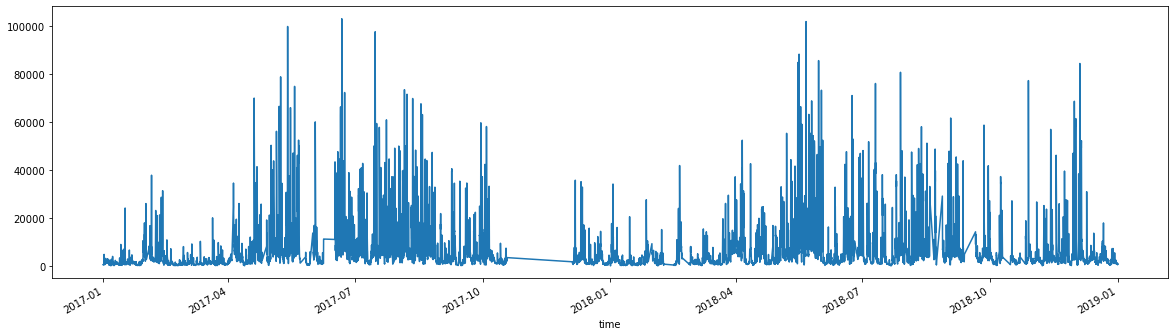

In [1017]:
(d1 * d1['dlDp']).sum('lDp').plot(figsize=(20,5),x='time')

In [1018]:
dpn = d2 + d3 

In [1019]:
dpn

<xarray.DataArray 'dndlDp' (secs: 51905, lDp: 29)>
array([[1.32913813e+05, 2.24564498e+05, 2.88669111e+05, ...,
        2.30980128e+05, 2.74321196e+05,            nan],
       [5.79885082e+05, 5.20847307e+05, 2.52911638e+05, ...,
        9.08562507e+05, 1.02076047e+06,            nan],
       [9.38659838e-08, 1.21641526e+03, 3.81953592e+03, ...,
        1.48644993e+04, 7.28075813e+03,            nan],
       ...,
       [6.15143118e+04, 5.15653298e+04, 2.53907295e+04, ...,
        1.39266090e+03, 7.43958339e+02,            nan],
       [2.41028192e+04, 2.74033677e+04, 2.19768662e+04, ...,
        1.15856301e+03, 7.25458696e+02,            nan],
       [2.64903740e+04, 2.44275029e+04, 1.40550196e+04, ...,
        1.21609841e+03, 6.37258124e+02,            nan]])
Coordinates:
    time     (secs) datetime64[ns] 2017-12-02T18:30:00 ... 2018-05-31T23:50:00
    Dp       (lDp) float64 1.024e-09 1.183e-09 1.367e-09 ... 5.617e-08 6.588e-08
  * lDp      (lDp) float64 -8.99 -8.927 -8.864 -8.802 ... -7.32 -7.25 -7.181
  * secs     (secs) float64 1.512e+09 1.512e+09 ... 1.528e+09 1.528e+09

In [1020]:
t1 = pd.to_datetime('2017-12-01')
t2 = pd.to_datetime('2018-06-01')

In [1021]:
def to_sec(date):
    s1 = date - np.datetime64(0, 'Y')
    s2 = s1 / np.timedelta64(1, 's')

    return s2

In [1022]:
s1 = to_sec(t1)
s2 = to_sec(t2)

In [1045]:
d11 = d1.loc[{'secs':slice(s1,s2)}]
d22 = dpn.loc[{'secs':slice(s1,s2)}]


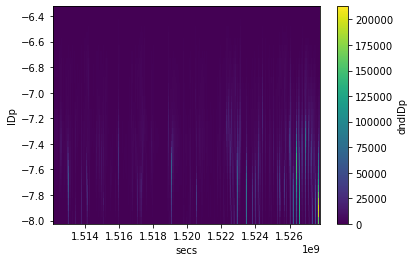

In [1046]:
d11.plot()

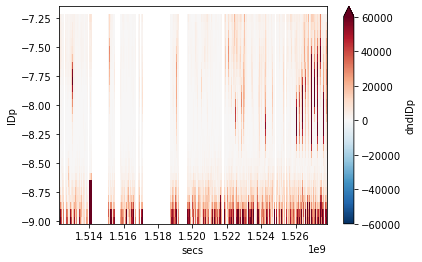

In [1047]:
(d22*2).plot(x='secs',vmax=60000)

In [1048]:
from banana_inspector.nodes.RegridBnnNode import RegridBnn
from banana_inspector.nodes.CombineSpectraNode import CombineSpectra
from banana_inspector.nodes.GaussianFilterNode import GaussianFilter

In [1049]:
d111 = RegridBnn.regrid(darray=d11,n_subs=11, log_dx=.05)
d222 = 4*RegridBnn.regrid(darray=d22,n_subs=11, log_dx=.05)

In [1034]:
_a = infer_interval_breaks(d111['lDp'])
d111['dlDp']=d111['lDp']*0 +( _a[1:] - _a[:-1])

In [1039]:
_d = d111 * d111['dlDp']

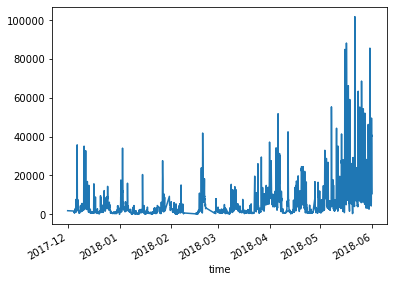

In [1044]:
_d.sum('lDp').plot(x='time')

In [1035]:
bo = d222.isnull().sum('lDp') < 5

In [1050]:

dc_ = CombineSpectra.combine_2_spectras(d222,d111,'lDp',-7.8)

In [1051]:
dc_ =dc_.where(bo)

In [1052]:
from useful_scit.imps2.defs import *

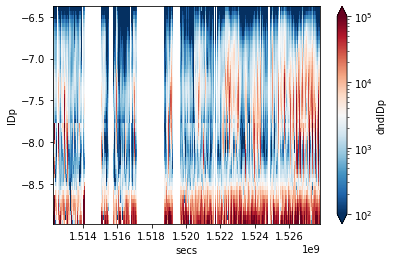

In [1053]:
dc_.plot(x='secs',norm=mpl.colors.LogNorm(vmin=100,vmax=100000))

In [1054]:
dc_1 = dc_.loc[{'lDp':slice(np.log10(3e-9),None)}];

In [1055]:
dc = GaussianFilter.gauss_astro(dc_1,.2,.05)

In [1058]:
# dc.plot(x='secs',norm=mpl.colors.LogNorm(vmin=100,vmax=100000))

In [1059]:
from banana_inspector.util import coag_sink as cs 

In [1060]:
dc['dlDp']=dc['lDp']*0+pd.Series(infer_interval_breaks(dc['lDp'] ,check_monotonic=True)).diff().dropna().values
daN = dc*dc['dlDp']
daN = daN.swap_dims({'lDp':'Dp'}) * 100*100*100

d1 = 3e-9
d2 = .7e-8
T = 293.15-15
P = 101325
alpha = 1

dens1 = dens2 = 1200

CoagSnk,td1,td2 = cs.calc_coag_snk_xr(daN, d1, d2, P, T, alpha, dens1, dens2)

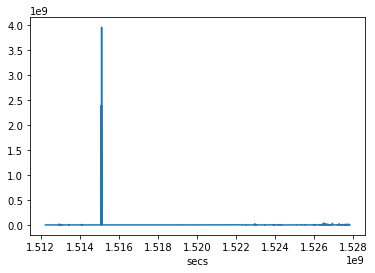

In [1061]:
CoagSnk.plot()

In [1062]:
dc__ = dc.loc[{'lDp':slice(-7.8,None)}]

In [1063]:
dc_1= (dc__ * dc__['dlDp'])

In [1064]:
def from_sec(sec):
    return pd.to_datetime(sec, unit='s')

In [1065]:
dc_1['time'] = dc_1['secs'].astype('datetime64[s]')

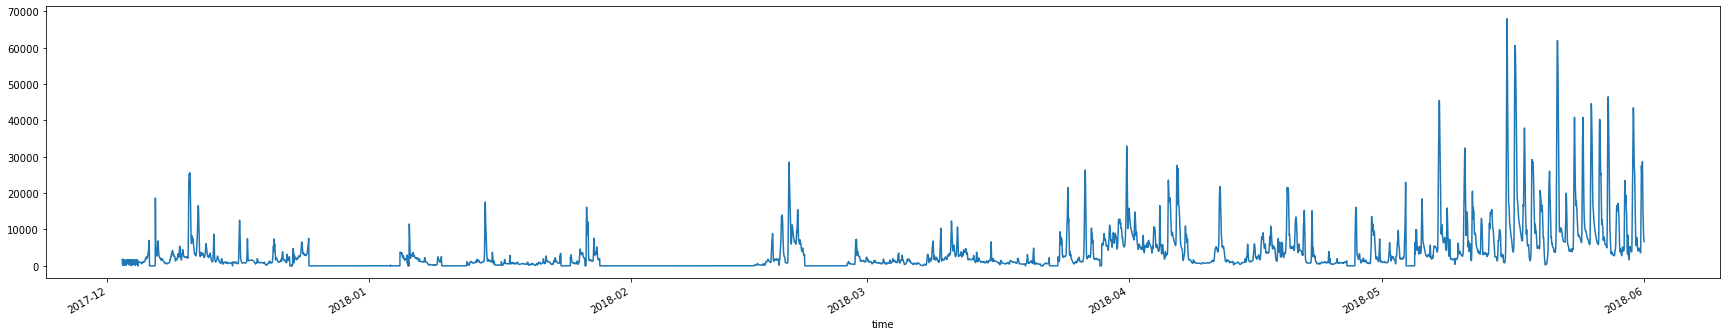

In [1066]:
dc_1.sum('lDp').plot(figsize=(30,5),x='time')

In [954]:
path = '/Volumes/mbProD/bolivia_campaign_analysis/inter_sys/x_array_data/master_xarray.h5'
ds = xr.open_dataset(path,group='master_set_v03')

In [1085]:
path_ = '/Volumes/mbProD/bolivia_campaign_data/PSM/data_v01/combined/psm_data_bolivia_campaign_2018.h5'

In [1086]:
ds1 = xr.open_dataset(path_)

In [1087]:
ds1

<xarray.Dataset>
Dimensions:                       (time: 15104897, id_left_scan: 133368)
Coordinates:
  * time                          (time) datetime64[ns] 2017-12-15T17:49:54 ....
    DAY                           (time) datetime64[ns] ...
  * id_left_scan                  (id_left_scan) datetime64[ns] 2017-12-25T18...
Data variables: (12/82)
    concentration_from_PSM_1_cm3  (time) float64 ...
    cut_off_diameter_nm           (time) float64 ...
    saturator_flow_rate_lpm       (time) float64 ...
    excess_flow_rate_lpm          (time) float64 ...
    PSM_saturator_T_C             (time) float64 ...
    growth_tube_T_C               (time) float64 ...
    ...                            ...
    Smp                           (time) float64 ...
    id_right_scan                 (id_left_scan) datetime64[ns] ...
    length_scan                   (id_left_scan) float64 ...
    length_round_scan             (id_left_scan) int64 ...
    PSM_saturator_T_C_scan        (id_left_scan) float64 ...
    PSM_saturator_T_C_round_scan  (id_left_scan) float64 ...

In [1081]:
ds

<xarray.Dataset>
Dimensions:                       (time: 15104897, id_left_scan: 133368)
Coordinates:
  * time                          (time) datetime64[ns] 2017-12-15T17:49:54 ....
    DAY                           (time) datetime64[ns] ...
  * id_left_scan                  (id_left_scan) datetime64[ns] 2017-12-25T18...
Data variables: (12/82)
    concentration_from_PSM_1_cm3  (time) float64 ...
    cut_off_diameter_nm           (time) float64 ...
    saturator_flow_rate_lpm       (time) float64 ...
    excess_flow_rate_lpm          (time) float64 ...
    PSM_saturator_T_C             (time) float64 ...
    growth_tube_T_C               (time) float64 ...
    ...                            ...
    Smp                           (time) float64 ...
    id_right_scan                 (id_left_scan) datetime64[ns] ...
    length_scan                   (id_left_scan) float64 ...
    length_round_scan             (id_left_scan) int64 ...
    PSM_saturator_T_C_scan        (id_left_scan) float64 ...
    PSM_saturator_T_C_round_scan  (id_left_scan) float64 ...

In [1088]:
pp = '/Volumes/mbProD/bolivia_campaign_data/PSM/data_v01/cpc_tsi/*.h5'

In [1089]:
ds = xr.open_mfdataset(pp)

In [1090]:
ds

<xarray.Dataset>
Dimensions:       (time: 8158361)
Coordinates:
  * time          (time) datetime64[ns] 2018-02-19T13:43:56 ... 2018-06-06T14...
Data variables:
    CPC_CONC_tsi  (time) float64 dask.array<chunksize=(1503,), meta=np.ndarray>

In [959]:
d11['lDp']

<xarray.DataArray 'lDp' (lDp: 34)>
array([-8.  , -7.95, -7.9 , -7.85, -7.8 , -7.75, -7.7 , -7.65, -7.6 , -7.55,
       -7.5 , -7.45, -7.4 , -7.35, -7.3 , -7.25, -7.2 , -7.15, -7.1 , -7.05,
       -7.  , -6.95, -6.9 , -6.85, -6.8 , -6.75, -6.7 , -6.65, -6.6 , -6.55,
       -6.5 , -6.45, -6.4 , -6.35])
Coordinates:
  * lDp      (lDp) float64 -8.0 -7.95 -7.9 -7.85 -7.8 ... -6.5 -6.45 -6.4 -6.35
    Dp       (lDp) float64 1e-08 1.122e-08 1.259e-08 ... 3.981e-07 4.467e-07

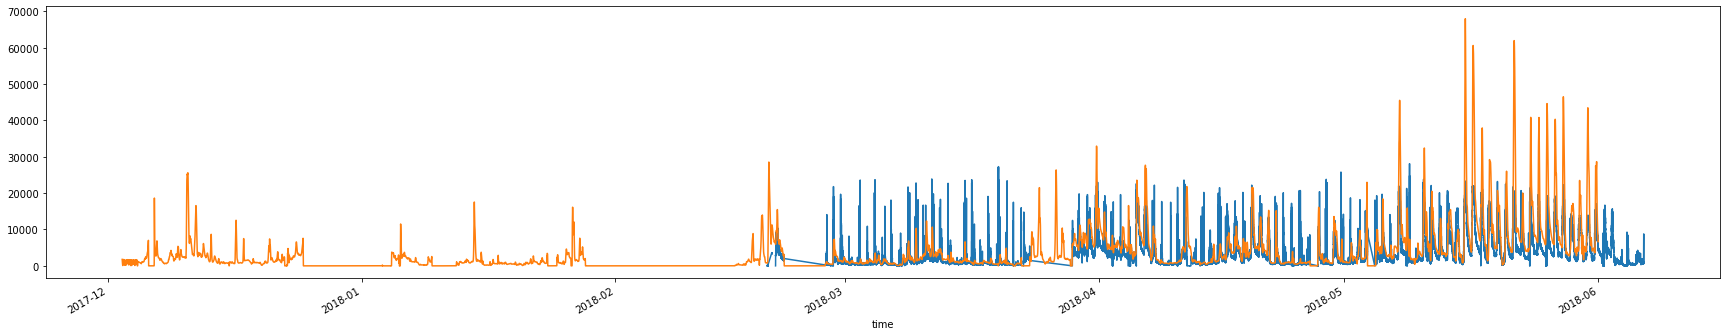

In [1091]:
_,ax = plt.subplots(figsize=(30,5))
(ds['CPC_CONC_tsi']).plot(ax=ax )
dc_1.sum('lDp').plot(x='time',ax=ax)

In [1092]:
ds['CPC_CONC_tsi']

<xarray.DataArray 'CPC_CONC_tsi' (time: 8158361)>
dask.array<concatenate, shape=(8158361,), dtype=float64, chunksize=(86400,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2018-02-19T13:43:56 ... 2018-06-06T14:10:19

In [1117]:
_dd = dc_1.sum('lDp').swap_dims({'secs':'time'})

In [1143]:
ds_=ds['CPC_CONC_tsi'].loc[{'time':'2018-05'}]
dd1 = _dd.loc[{'time':'2018-05'}]

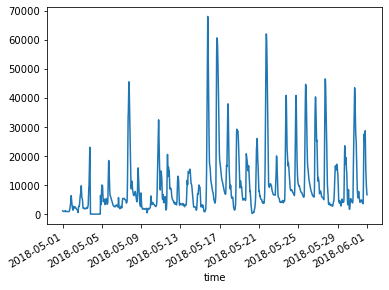

In [1144]:
dd1.plot()

/Users/aliaga/miniforge3/envs/q5/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:997: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


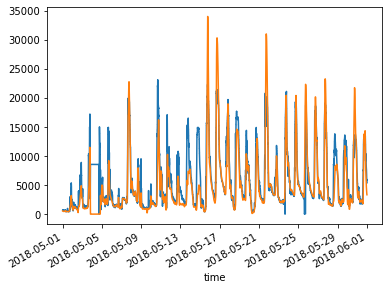

In [1145]:
ds_.rolling(time=1200,min_periods=1).median().plot()
(dd1/2).plot()

In [963]:
CoagS

<xarray.DataArray (Dp12: 9)>
array([1.37275315e-11, 9.72649877e-12, 6.89088123e-12, 4.88010810e-12,
       3.45298748e-12, 2.43869807e-12, 1.71628894e-12, 1.20024146e-12,
       8.30383240e-13])
Coordinates:
  * Dp12     (Dp12) float64 1.585e-09 1.995e-09 2.512e-09 ... 7.943e-09 1e-08

In [970]:
cs1 = CoagSnk.where(bo)/1e6

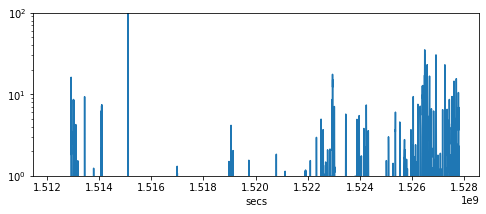

In [975]:
cs1.plot(yscale='log',figsize=(8,3),ylim=[1,100])

In [768]:
import pyqtgraph as pg

In [769]:
cs1

<xarray.DataArray (secs: 51905)>
array([3.43206683e-07, 1.38016035e-07, 7.46195382e-08, ...,
       2.54228911e-07, 2.32634079e-07, 2.14051758e-07])
Coordinates:
  * secs     (secs) float64 1.512e+09 1.512e+09 ... 1.528e+09 1.528e+09
    time     (secs) datetime64[ns] 2017-12-02T18:30:00 ... 2018-05-31T23:50:00

In [770]:
%gui qt5

In [771]:
pg.plot(x=cs1['secs'].values,y=np.log10(cs1.values)).show()

In [772]:
pp = '/Users/aliaga/py-packs/banana-inspector-parent/banana-inspector/examples/npf_iden_neg_ion_nais_smpsBackUp/*.csv'

ps = glob.glob(pp)
ps.sort()

Text(0, 0.5, 'GR 1.0-3.0 nm')

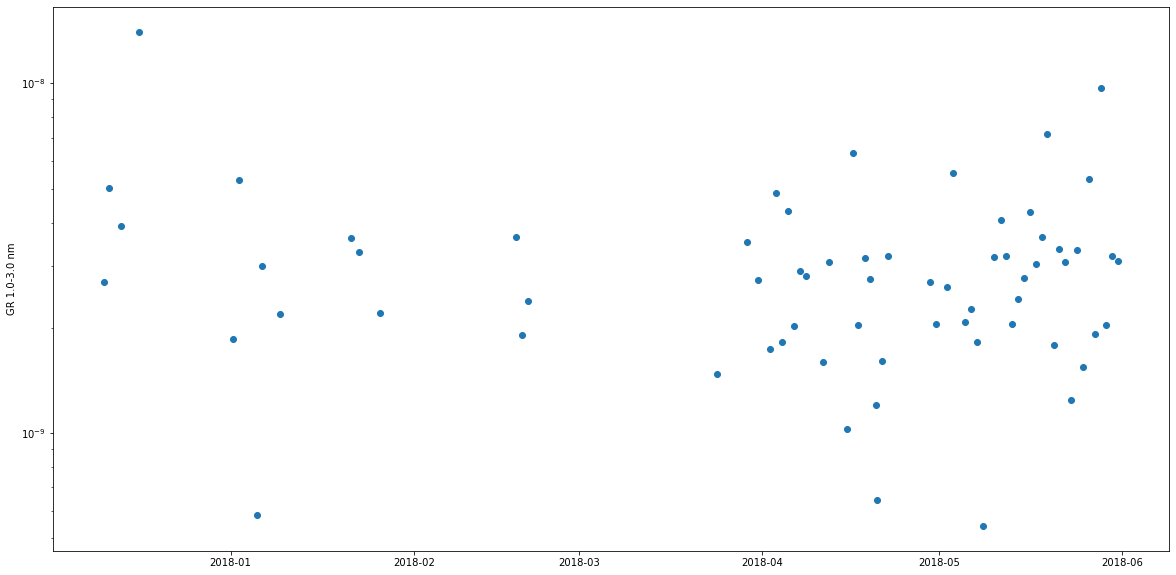

In [983]:
d1_ = 1e-9
d2_ = 3e-9
fs = [] 
for p in ps:
    try:
        r = get_row(p,d1_,d2_) 
        fs.append(r)
    except: pass

df1 = pd.concat(fs).set_index('date')

fff1=df2 = df1[df1['gr']>0]

_,ax=plt.subplots(figsize=(20,10))
ax.scatter(df2.index, df2['gr'] )
plt.gca().set_yscale('log')
ax.set_ylabel(f'GR {d1_*1e9}-{d2_*1e9} nm')

Text(0, 0.5, 'GR 3-7nm')

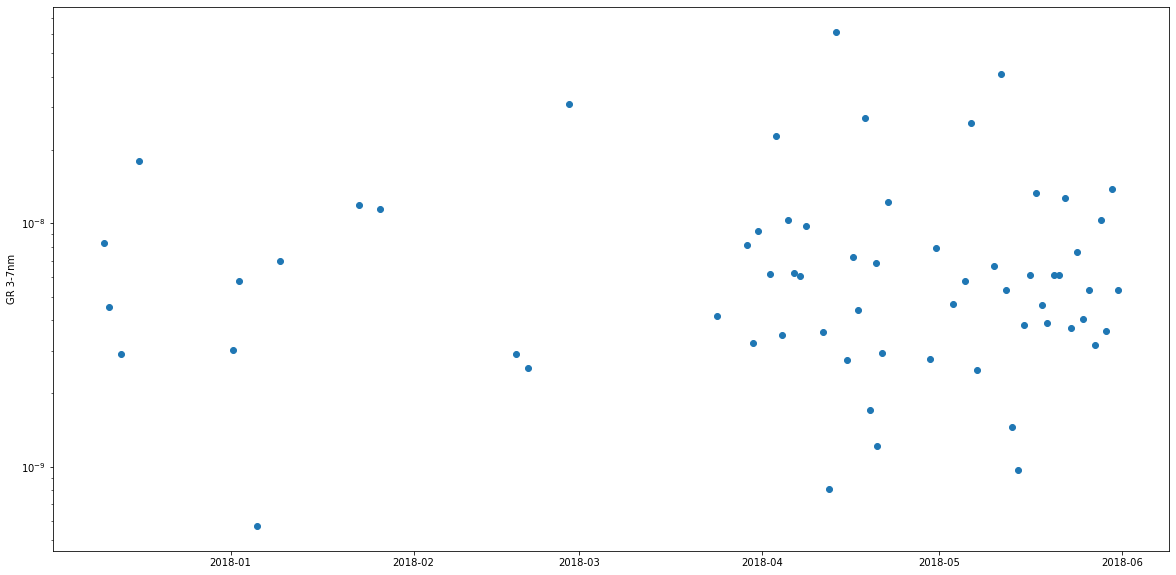

In [984]:
def get_row(p,d1,d2):
    from sklearn import linear_model
    csv1 = pd.read_csv(p)

    c_ = csv1.set_index('Dp')


    c_1 = c_[(c_.index > d1) &(c_.index<d2)]

    c_2 = c_1.reset_index().set_index(c_1['x']/3600 - c_1['x'].iloc[0]/3600)

    c_3 = c_1.reset_index().set_index(c_1['x'] - c_1['x'].iloc[0])




    X = c_3.index.values.reshape(-1, 1)

    y = c_3['Dp']

    lm = linear_model.LinearRegression()
    model = lm.fit(X,y)

    gr = model.coef_ * 3600
    sec = c_1['x'].iloc[0]
    data = pd.to_datetime(sec*1e9)
    f = {'gr':gr,'secs': c_1['x'].iloc[0],'d1':d1,'d2':d2,'date':data}
    return pd.DataFrame(f)

fs = [get_row(p,d1,d2) for p in ps]

df1 = pd.concat(fs).set_index('date')

fff2 = df2 = df1[df1['gr']>0]

_,ax=plt.subplots(figsize=(20,10))
ax.scatter(df2.index, df2['gr'] )
plt.gca().set_yscale('log')
ax.set_ylabel('GR 3-7nm')

Text(0, 0.5, 'GR 7.0-20.0 nm')

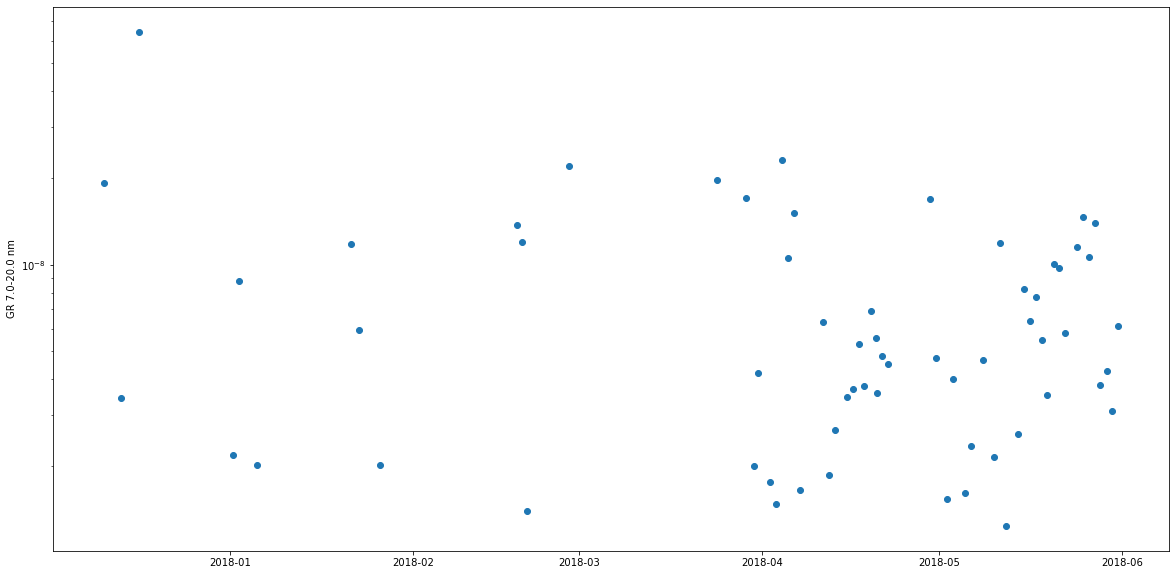

In [985]:
d1_ = 7e-9
d2_ = 20e-9
fs = [] 
for p in ps:
    try:
        r = get_row(p,d1_,d2_) 
        fs.append(r)
    except: pass

df1 = pd.concat(fs).set_index('date')

fff3 = df2 = df1[df1['gr']>0]

_,ax=plt.subplots(figsize=(20,10))
ax.scatter(df2.index, df2['gr'] )
plt.gca().set_yscale('log')
ax.set_ylabel(f'GR {d1_*1e9}-{d2_*1e9} nm')

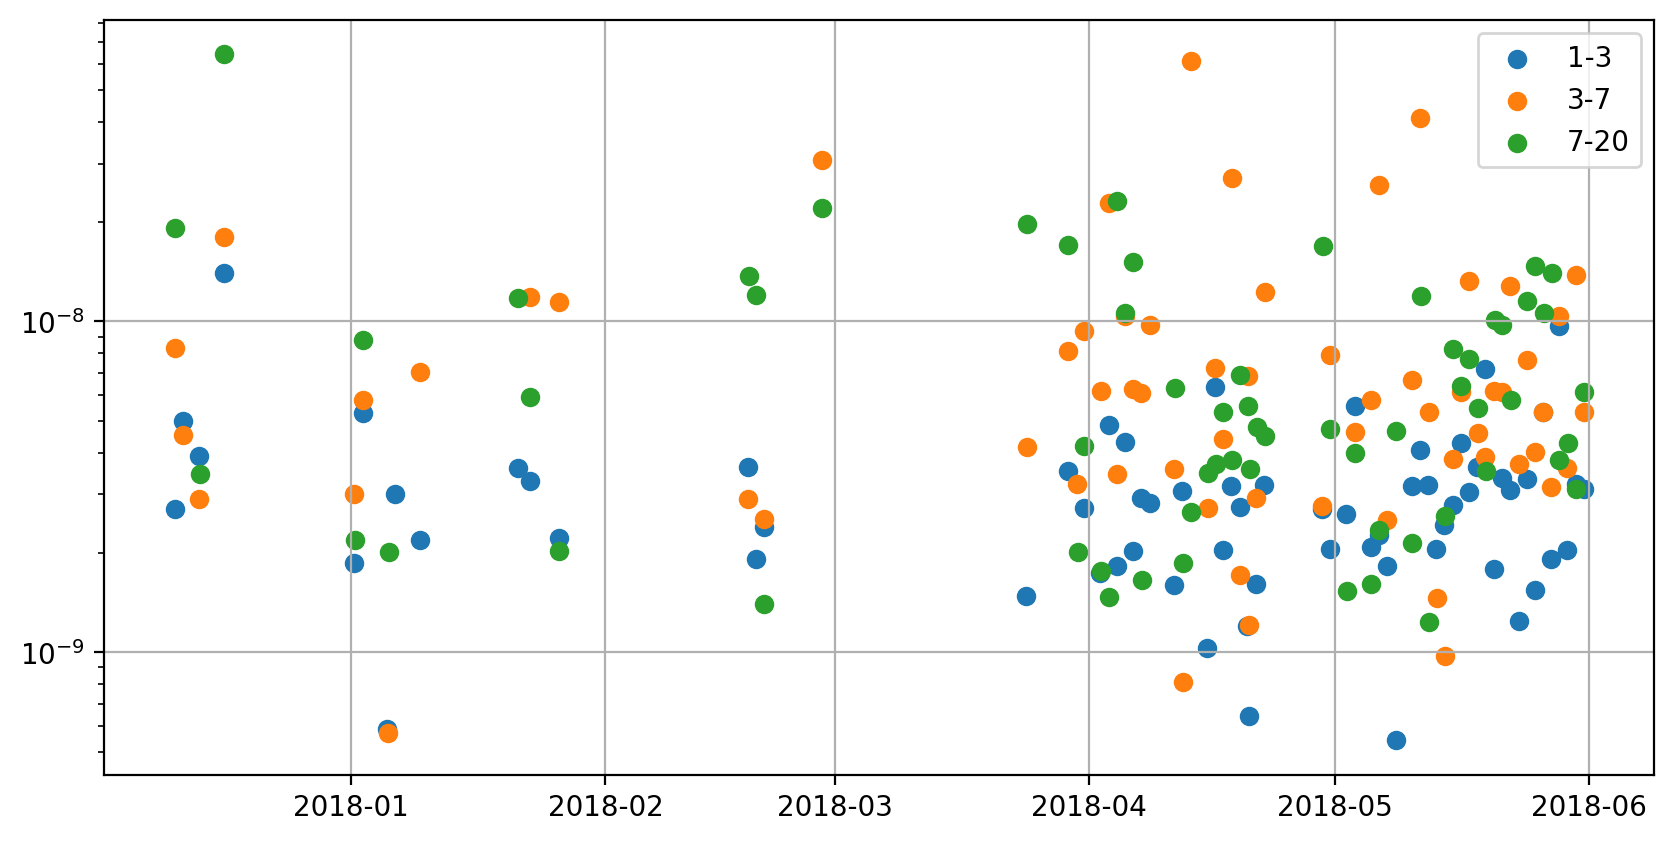

In [997]:
f,ax = plt.subplots(figsize=[10,5],dpi=200)
ax.scatter(fff1.index,fff1['gr'],label='1-3')
ax.scatter(fff2.index,fff2['gr'],label='3-7')
ax.scatter(fff3.index,fff3['gr'],label='7-20')
ax.legend()
ax.set_yscale('log')
ax.grid()

/Users/aliaga/miniforge3/envs/q5/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/aliaga/miniforge3/envs/q5/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/aliaga/miniforge3/envs/q5/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

Text(0.5, 1.0, 'gr[nm/h] 7-20')

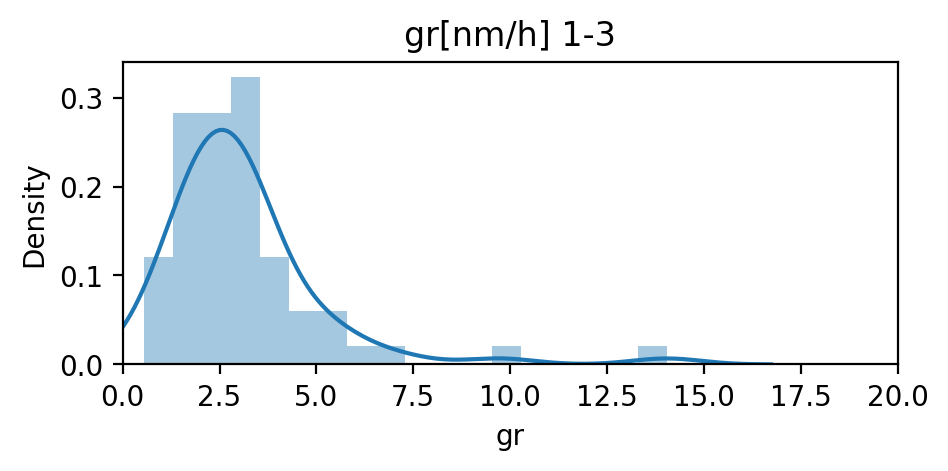

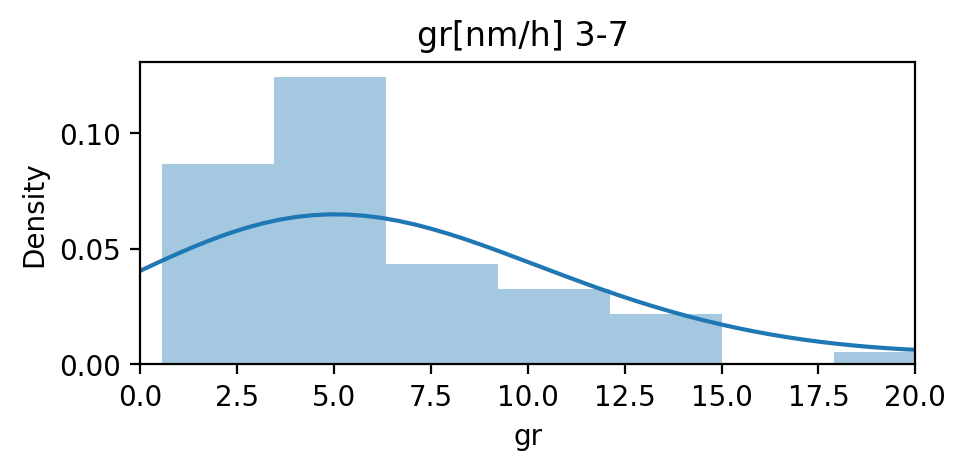

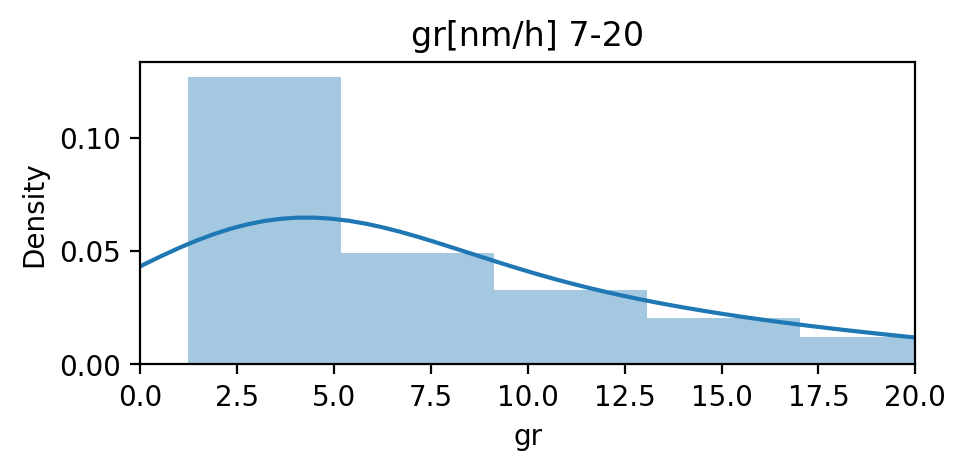

In [1011]:
f,ax = plt.subplots(figsize=[5,2],dpi=200)
sns.distplot(fff1['gr']*1e9,ax=ax)
ax.set_xlim(0,20)
ax.set_title('gr[nm/h] 1-3')
f,ax = plt.subplots(figsize=[5,2],dpi=200)
sns.distplot(fff2['gr']*1e9,ax=ax)
ax.set_xlim(0,20)
ax.set_title('gr[nm/h] 3-7 ')
f,ax = plt.subplots(figsize=[5,2],dpi=200)
sns.distplot(fff3['gr']*1e9,ax=ax)
ax.set_xlim(0,20)
ax.set_title('gr[nm/h] 7-20')

In [856]:
dN = dc*dc['dlDp']

In [885]:
dN1 = dN.loc[{'lDp':slice(np.log10(d1),np.log10(d2))}]
dNT = dN

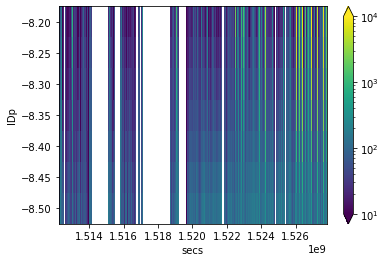

In [876]:
dN1.plot(norm = mpl.colors.LogNorm(vmin=10,vmax = 1e4))

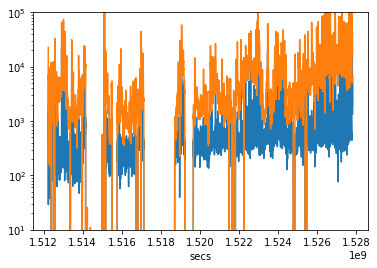

In [888]:
dN1.sum('lDp').plot(ylim=[10,100000],yscale='log')
dNT.sum('lDp').plot(ylim=[10,100000],yscale='log')

In [867]:
dNdt = dN1.diff('secs').sum('lDp')

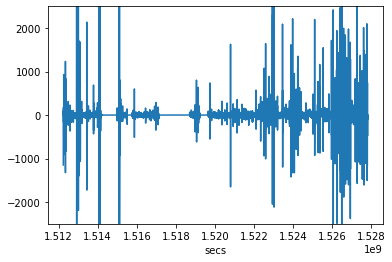

In [872]:
dNdt.plot(ylim=[-2500,2500])